In [1]:
import warnings
import torch
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
import numpy as np

In [2]:
df_train = pd.read_csv('data/twitter_training.csv', header=None, names=["id", "company", "sentiment", "text"])
df_val = pd.read_csv('data/twitter_validation.csv', header=None, names=["id", "company", "sentiment", "text"])
df_val.head()

,id,company,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [3]:
valid_sentiments = {"Negative", "Neutral", "Positive"}

df_train = df_train[df_train["sentiment"].isin(valid_sentiments)]
df_val = df_val[df_val["sentiment"].isin(valid_sentiments)]

label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df_train["label"] = df_train["sentiment"].map(label_map).astype(int)
df_val["label"] = df_val["sentiment"].map(label_map).astype(int)

df_train["text"] = df_train["text"].astype(str)
df_val["text"] = df_val["text"].astype(str)

In [4]:
SEQ_LENGTH = 32

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(df_train["text"].tolist(),padding=True,truncation=True,max_length=SEQ_LENGTH)
val_encodings = tokenizer(df_val["text"].tolist(),padding=True,truncation=True,max_length=SEQ_LENGTH)

train_labels = df_train["label"].tolist()
val_labels = df_val["label"].tolist()

In [5]:
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, num_classes=3, seq_len=SEQ_LENGTH, hidden_dim=256, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, seq_len, hidden_dim))

        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                batch_first=True
            )
            for _ in range(num_layers)
        ])

        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = []

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        x = x + self.position_embedding[:, :x.size(1), :]

        if attention_mask is not None:
            key_padding_mask = attention_mask == 0
        else:
            key_padding_mask = None

        self.attention_weights.clear()

        for layer in self.encoder_layers:
            attn_output, attn_weights = layer.self_attn(
                x, x, x,
                key_padding_mask=key_padding_mask,
                need_weights=True,
                attn_mask=None,
                average_attn_weights=False
            )
            self.attention_weights.append(attn_weights)
            x = layer.dropout1(attn_output + x)
            x = layer.norm1(x)
            x2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
            x = layer.dropout2(x2 + x)
            x = layer.norm2(x)

        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.fc(x)

class TwitterSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

In [22]:
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentTransformer(vocab_size=tokenizer.vocab_size,num_classes=3).to(device)

train_dataset = TwitterSentimentDataset(train_encodings, train_labels)
val_dataset = TwitterSentimentDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 15

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    train_acc = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)
    print(f"    Train Loss: {avg_train_loss:.4f} | Accuracy: {train_acc:.4f}")

    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_acc = accuracy_score(all_labels, all_preds)
    avg_val_loss = total_loss / len(val_loader)
    print(f"    Val Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


Epoch 1/15
    Train Loss: 0.7620 | Accuracy: 0.6711
    Val Loss: 0.5057 | Accuracy: 0.8116

Epoch 2/15
    Train Loss: 0.5461 | Accuracy: 0.7813
    Val Loss: 0.4688 | Accuracy: 0.8309

Epoch 3/15
    Train Loss: 0.4585 | Accuracy: 0.8192
    Val Loss: 0.3763 | Accuracy: 0.8780

Epoch 4/15
    Train Loss: 0.3946 | Accuracy: 0.8467
    Val Loss: 0.2865 | Accuracy: 0.8973

Epoch 5/15
    Train Loss: 0.3446 | Accuracy: 0.8664
    Val Loss: 0.3044 | Accuracy: 0.8986

Epoch 6/15
    Train Loss: 0.3065 | Accuracy: 0.8818
    Val Loss: 0.2761 | Accuracy: 0.9143

Epoch 7/15
    Train Loss: 0.2874 | Accuracy: 0.8880
    Val Loss: 0.3024 | Accuracy: 0.9082

Epoch 8/15
    Train Loss: 0.2633 | Accuracy: 0.8966
    Val Loss: 0.2516 | Accuracy: 0.9263

Epoch 9/15
    Train Loss: 0.2454 | Accuracy: 0.9036
    Val Loss: 0.2322 | Accuracy: 0.9336

Epoch 10/15
    Train Loss: 0.2378 | Accuracy: 0.9058
    Val Loss: 0.1995 | Accuracy: 0.9517

Epoch 11/15
    Train Loss: 0.2105 | Accuracy: 0.9161
    

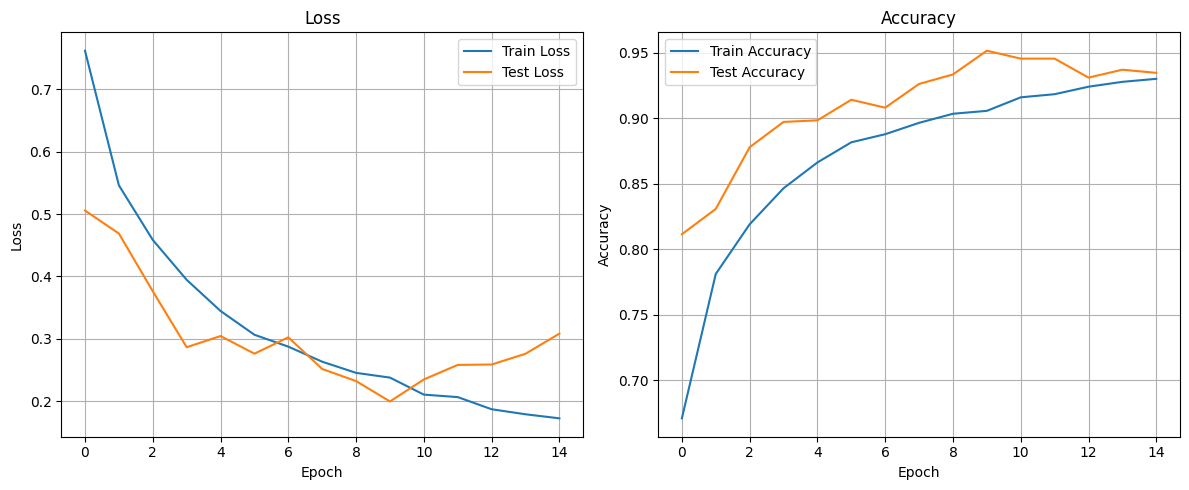

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [14]:
def plot_attention_weights(attention_weights, layer_idx, seq_len=None):
    attn = attention_weights[layer_idx][0]
    attn = attn.mean(dim=0).detach().cpu().numpy()

    if seq_len is not None:
        attn = attn[:seq_len, :seq_len]

    plt.figure(figsize=(8, 6))
    plt.imshow(attn, cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title(f"Attention Weights")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

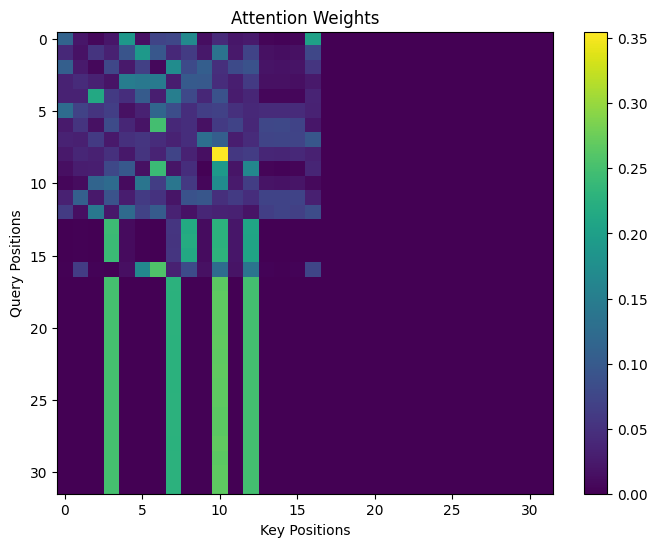

In [18]:
num_plots = 1
num_layers = len(model.attention_weights)
layers_to_plot = np.linspace(0, num_layers - 1, num_plots, dtype=int)

for layer_idx in layers_to_plot:
    plot_attention_weights(model.attention_weights, layer_idx)

# Summary

1) Based on heatmap, it is evident that model uses first 10-20 tokens

2) I use distilbert-tokenizer that splits text into words from a dictionary

3) The bright dot seems to

4) Vertical stripes